## Data from Owid. ##

https://github.com/owid/co2-data/blob/master/README.md

International Enegergy data - U.S. Energy Information Administration

CO2 Data - Global Carbon Project, National fossil carbon emissions

GDP - University of Groningen GGDC's Maddison Project Database, Bolt and van Zanden, 2024

Dataset shape: (50191, 79)
Countries in dataset: 255
Year range: 1750 to 2023
Missing values: 2105991
G20 dataset shape: (3725, 79)
G20 countries included in analysis (19): ['Argentina' 'Australia' 'Brazil' 'Canada' 'China' 'France' 'Germany'
 'India' 'Indonesia' 'Italy' 'Japan' 'Mexico' 'Russia' 'Saudi Arabia'
 'South Africa' 'South Korea' 'Turkey' 'United Kingdom' 'United States']
Potential features for selection: 5
['population', 'gdp', 'energy_per_capita', 'energy_per_gdp', 'primary_energy_consumption']

Features with missing values: 4 out of 5

Applying feature selection methods...

 1. LASSO Feature Selection
Optimal alpha: 0.026051
LASSO selected 4 features
Top 10 LASSO selected features:
                      Feature  Coefficient  Abs_Coefficient
2           energy_per_capita     4.579610         4.579610
3              energy_per_gdp     0.817616         0.817616
0                  population    -0.700989         0.700989
4  primary_energy_consumption     0.681968         0.68

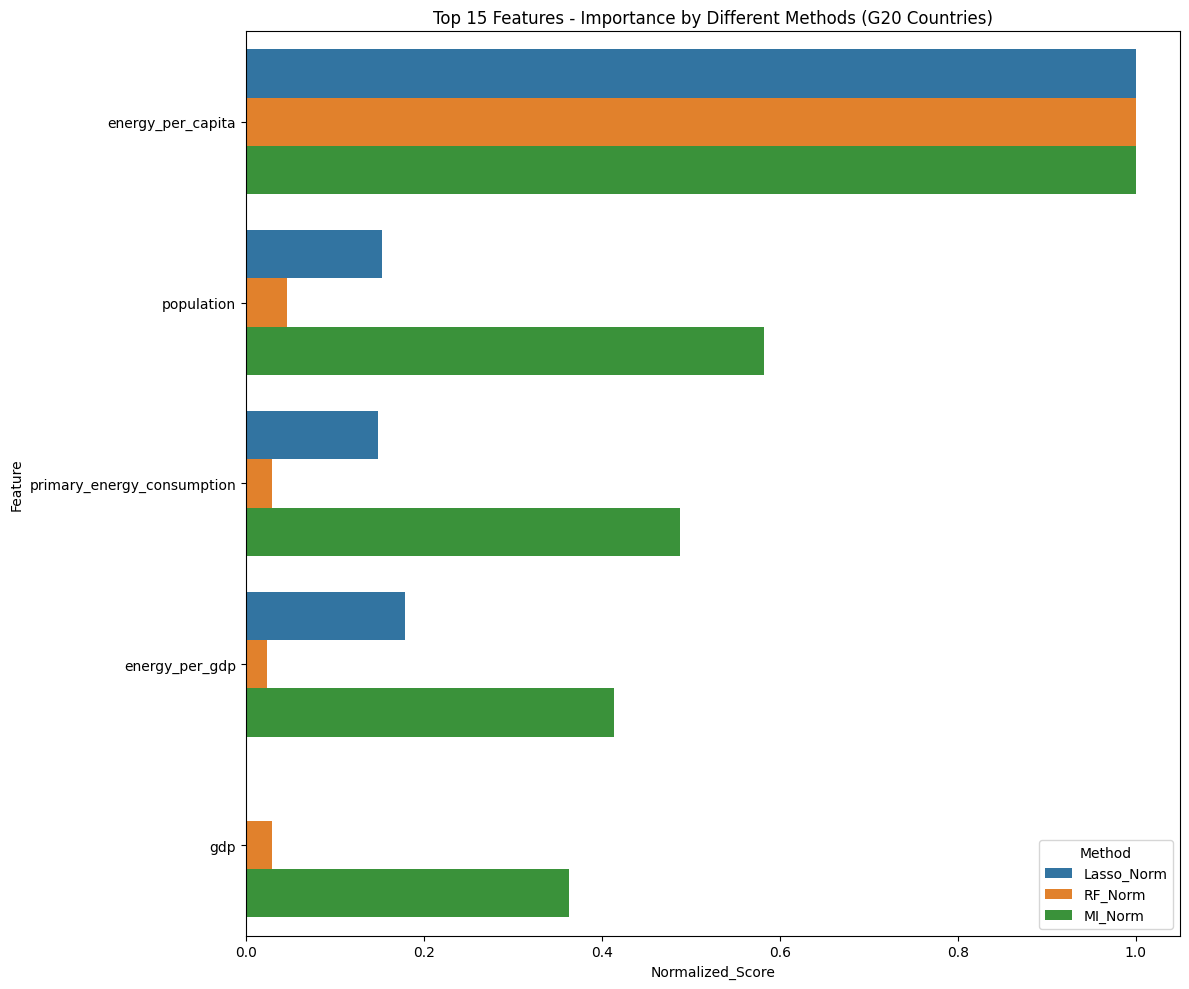

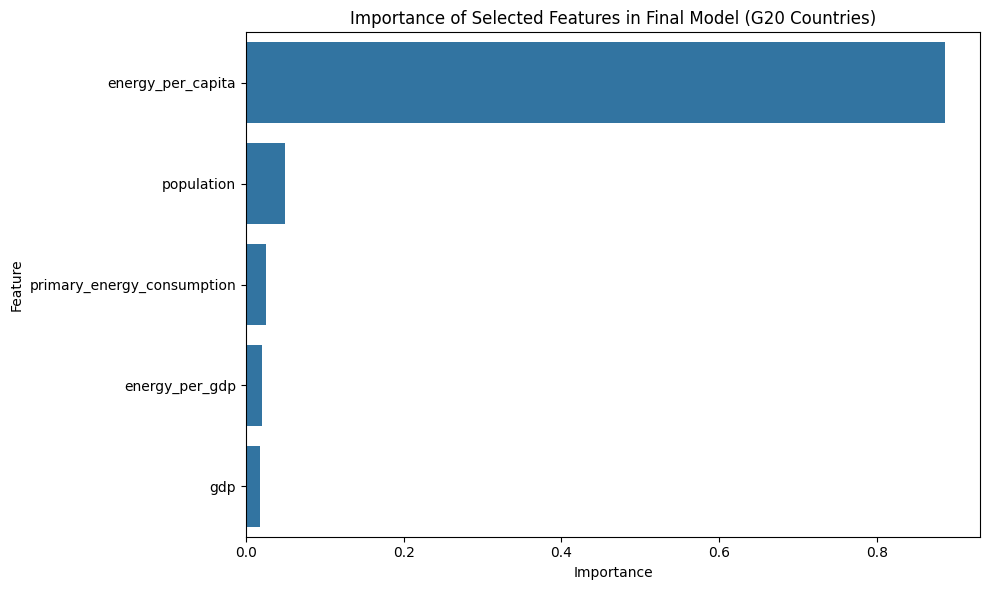

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define G20 countries
g20_countries = [
    'United States', 'China', 'Japan', 'Germany', 
    'United Kingdom', 'France', 'Italy', 'Canada',
    'Brazil', 'Russia', 'India', 'Australia', 
    'Mexico', 'Indonesia', 'Turkey', 'Saudi Arabia',
    'South Africa', 'Argentina', 'South Korea'
]

# Load the data
df = pd.read_csv("https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv")

# Data check
print(f"Dataset shape: {df.shape}")
print(f"Countries in dataset: {df['country'].nunique()}")
print(f"Year range: {df['year'].min()} to {df['year'].max()}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Filter for G20 countries
df_g20 = df[df['country'].isin(g20_countries)]
print(f"G20 dataset shape: {df_g20.shape}")

# Select a target variable
target_variable = 'co2_per_capita'

df_filtered = df_g20.dropna(subset=[target_variable])

# subset of 50 years
recent_years = 50
latest_year = df_filtered['year'].max()
df_recent = df_filtered[df_filtered['year'] >= (latest_year - recent_years)]

# Check country coverage
countries_included = df_recent['country'].unique()
print(f"G20 countries included in analysis ({len(countries_included)}): {countries_included}")
missing_countries = set(g20_countries) - set(countries_included)
if missing_countries:
    print(f"Missing G20 countries: {missing_countries}")

# Select potential features
# Exclude target-related columns and non-numeric columns
exclude_patterns = ['co2', 'ghg', 'methane', 'nitrous_oxide', 'temperature', 'cumulative', 'share_global']
potential_features = [col for col in df_recent.columns 
                      if not any(pattern in col for pattern in exclude_patterns)
                      and col not in ['country', 'year', 'iso_code']]

print(f"Potential features for selection: {len(potential_features)}")
print(potential_features)

# Data for feature selection
X = df_recent[potential_features].copy()
y = df_recent[target_variable].copy()

missing_values = X.isnull().sum()
print(f"\nFeatures with missing values: {(missing_values > 0).sum()} out of {len(potential_features)}")

X = X.fillna(X.mean())

# Duplication of a separate dataset with countries and years
reference_data = df_recent[['country', 'year']].copy()

# Scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# TTS
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("\nApplying feature selection methods...")

### LASSO
print("\n 1. LASSO Feature Selection")
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(X_train, y_train)
print(f"Optimal alpha: {lasso_cv.alpha_:.6f}")


lasso = Lasso(alpha=lasso_cv.alpha_, random_state=42)
lasso.fit(X_train, y_train)

# LASSO coefficients
lasso_coefs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
})
lasso_coefs['Abs_Coefficient'] = np.abs(lasso_coefs['Coefficient'])
lasso_selected = lasso_coefs[lasso_coefs['Coefficient'] != 0].sort_values('Abs_Coefficient', ascending=False)

print(f"LASSO selected {len(lasso_selected)} features")
print("Top 10 LASSO selected features:")
print(lasso_selected.head(10))

### Random Forest
print("\n2. Random Forest Feature Importance")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
rf_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 features by Random Forest importance:")
print(rf_importances.head(10))

### Mutual Information
print("\n3. Mutual Information")
mi_scores = mutual_info_regression(X_train, y_train, random_state=42)
mi_results = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("Top 10 features by Mutual Information:")
print(mi_results.head(10))

# Combine results for comparison
print("\n--- Combined Feature Rankings ---")
lasso_coefs['Lasso_Norm'] = lasso_coefs['Abs_Coefficient'] / lasso_coefs['Abs_Coefficient'].max() 
rf_importances['RF_Norm'] = rf_importances['Importance'] / rf_importances['Importance'].max()
mi_results['MI_Norm'] = mi_results['MI_Score'] / mi_results['MI_Score'].max()

# Create a combined ranking
combined_ranks = pd.DataFrame({'Feature': X.columns})
combined_ranks = combined_ranks.merge(lasso_coefs[['Feature', 'Lasso_Norm']], on='Feature', how='left')
combined_ranks = combined_ranks.merge(rf_importances[['Feature', 'RF_Norm']], on='Feature', how='left')
combined_ranks = combined_ranks.merge(mi_results[['Feature', 'MI_Norm']], on='Feature', how='left')
combined_ranks['Lasso_Norm'] = combined_ranks['Lasso_Norm'].fillna(0)
combined_ranks['Average_Norm'] = combined_ranks[['Lasso_Norm', 'RF_Norm', 'MI_Norm']].mean(axis=1)
combined_ranks = combined_ranks.sort_values('Average_Norm', ascending=False)

print("Top 15 features by combined normalized score:")
print(combined_ranks.head(15))

# Visualize the top 15 features
plt.figure(figsize=(12, 10))
top_features = combined_ranks.head(15)['Feature'].tolist()

# Data plot
plot_data = pd.melt(
    combined_ranks[combined_ranks['Feature'].isin(top_features)]
    [['Feature', 'Lasso_Norm', 'RF_Norm', 'MI_Norm']], 
    id_vars=['Feature'], 
    var_name='Method', 
    value_name='Normalized_Score'
)

# Plot
sns.barplot(x='Normalized_Score', y='Feature', hue='Method', data=plot_data)
plt.title('Top 15 Features - Importance by Different Methods (G20 Countries)')
plt.tight_layout()
plt.savefig('g20_feature_importance_comparison.png')
print("\nFeature importance visualization saved as 'g20_feature_importance_comparison.png'")

# Evaluate models with selected features
print("\n--- Model Evaluation with Selected Features ---")
top_n_features = 10
selected_features = combined_ranks.head(top_n_features)['Feature'].tolist()
print(f"Selected top {top_n_features} features for model training:")
print(selected_features)

# Prepare data with only selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train model with selected features
rf_selected = RandomForestRegressor(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, y_train)

# Predictions
y_pred = rf_selected.predict(X_test_selected)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error with top {top_n_features} features: {mse:.4f}")
print(f"R2 Score with top {top_n_features} features: {r2:.6f}")

# Compare with a model using all features
print("\nComparing with model using all features:")
rf_all = RandomForestRegressor(n_estimators=100, random_state=42)
rf_all.fit(X_train, y_train)
y_pred_all = rf_all.predict(X_test)
mse_all = mean_squared_error(y_test, y_pred_all)
r2_all = r2_score(y_test, y_pred_all)
print(f"Mean Squared Error with all features: {mse_all:.4f}")
print(f"R2 Score with all features: {r2_all:.4f}")
print(f"Feature reduction: {len(potential_features)} → {top_n_features} features")

# Feature importance analysis for the selected model
print("\n--- Feature Importance of Selected Features ---")
selected_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_selected.feature_importances_
}).sort_values('Importance', ascending=False)

print("Importance ranking of selected features:")
print(selected_importances)

# Plot feature importance of selected features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=selected_importances)
plt.title('Importance of Selected Features in Final Model (G20 Countries)')
plt.tight_layout()
plt.savefig('g20_selected_features_importance.png')
print("\nSelected features importance visualization saved as 'g20_selected_features_importance.png'")